# 📌 NYC Restaurant Inspection Risk Prediction

### 🧪 Insights & GenAI

In this notebook, we will:

1. **Perform hyperparameter tuning** on four models: Logistic Regression, Decision Tree, Random Forest, and Gradient Boosting, optimizing parameters based on the validation set.

2. **Evaluate two scenarios:** one excluding `violation_code`, a variable highly predictive of the target—and one including it.

3. **Select the best model and scenario** by comparing performance metrics to identify the most suitable approach for this task.

### Dependencies

In [1]:
import sys
import shap
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from os.path import join, abspath

# adding the root folder to the system path
if abspath('..') not in sys.path:
    sys.path.append(abspath('..'))

from src.path_manager import PathManager

# path manager to handle paths
path_manager = PathManager()
processed_data_path = path_manager.processed_data_path
clean_data_path = path_manager.clean_data_path
models_path = path_manager.models_path

# ignore warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
# feature types according to NYC open data portal
dtypes = {
    'camis': 'string',
    'dba': 'string',
    'boro': 'string',
    'building': 'string',
    'street': 'string',
    'zipcode': 'string',
    'cuisine_description': 'string',
    'action': 'string',
    'violation_code': 'string',
    'violation_description': 'string',
    'critical_flag': 'string',
    'score': 'float',
    'grade': 'string',
    'inspection_type': 'string',
    'latitude': 'float',
    'longitude': 'float',
}

# date column to parse
parse_dates = ['inspection_date']

# import data
train_df = pd.read_csv(
    join(clean_data_path, 'clean_train.csv'),
    dtype=dtypes,
    parse_dates=parse_dates,
    ).set_index('key')

val_df = pd.read_csv(
    join(clean_data_path, 'clean_val.csv'),
    dtype=dtypes,
    parse_dates=parse_dates,
    ).set_index('key')

test_df = pd.read_csv(
    join(clean_data_path, 'clean_test.csv'),
    dtype=dtypes,
    parse_dates=parse_dates,
    ).set_index('key')

# append all dataframes
combined_df = pd.concat([train_df, val_df, test_df], axis=0)

display(combined_df.head(3))

,camis,dba,boro,building,street,zipcode,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,inspection_type,latitude,longitude,inspection_id
key,,,,,,,,,,,,,,,,,,
40944945_24-09-15_10B,40944945,Stage 42,Manhattan,422,West 42 Street,10036,American,2015-09-24,Establishment re-opened by DOHMH.,10B,plumbing properly installed maintained anti si...,Not Critical,2.0,A,Other,40.758823,-73.993607,40944945_24-09-15
50015538_19-11-15_10B,50015538,American Airlines Theater,Manhattan,227,West 42 Street,10036,American,2015-11-19,Violations were cited in the following area(s).,10B,plumbing properly installed maintained anti si...,Not Critical,12.0,A,Cycle Inspection / Initial Inspection,40.756531,-73.988117,50015538_19-11-15
50015171_20-11-15_10F,50015171,New Amsterdam Theater,Manhattan,214,West 42 Street,10036,American,2015-11-20,Violations were cited in the following area(s).,10F,non food contact surface improperly constructe...,Not Critical,10.0,A,Cycle Inspection / Initial Inspection,40.756317,-73.987652,50015171_20-11-15


In [3]:
# import data
processed_train = pd.read_csv(join(processed_data_path, 'processed_train.csv')).set_index('key')
processed_val = pd.read_csv(join(processed_data_path, 'processed_val.csv')).set_index('key')
processed_test = pd.read_csv(join(processed_data_path, 'processed_test.csv')).set_index('key')

# separate target and features
target_feature = 'critical_flag'

X_train = processed_train.drop([target_feature, 'violation_code'], axis=1)
y_train = processed_train[target_feature]

X_val = processed_val.drop([target_feature, 'violation_code'], axis=1)
y_val = processed_val[target_feature]

X_test = processed_test.drop([target_feature, 'violation_code'], axis=1)
y_test = processed_test[target_feature]

full_len = len(X_train) + len(X_val) + len(X_test)
print(
    f'Train: {X_train.shape} -> {round(len(X_train)/full_len*100)}%',
    f'\nValidation: {X_val.shape} -> {round(len(X_val)/full_len*100)}%'
    f'\nTest: {X_test.shape} -> {round(len(X_test)/full_len*100)}%',
)

display(X_train.head(3))

Train: (64286, 14) -> 69% 
Validation: (14388, 14) -> 15%
Test: (14433, 14) -> 16%


,dba,building,street,zipcode,cuisine_description,score,inspection_month,inspection_year,inspection_type_other,desc_length_chars,critical_token_count,negative_sentiment,tfidf_cleaning,tfidf_food
key,,,,,,,,,,,,,,
30075445_31-01-23_10D,0.609112,0.754557,0.791582,0.611277,0.444058,0.435218,0.0,0.888889,0.0,0.252874,0.000000,1.0,0.0,0.000000
30075445_31-01-23_06D,0.609112,0.754557,0.791582,0.611277,0.444058,0.435218,0.0,0.888889,0.0,0.139573,0.384615,1.0,0.0,0.066933
30075445_31-01-23_04N,0.609112,0.754557,0.791582,0.611277,0.444058,0.435218,0.0,0.888889,0.0,0.270936,0.923077,1.0,0.0,0.073791


In [4]:
# load trained model
model = joblib.load(join(models_path, 'GB1.pkl'))

In [5]:
# load lightweight gpt model
generator = pipeline('text-generation', model='distilgpt2')

Device set to use mps:0


### Feature Importance

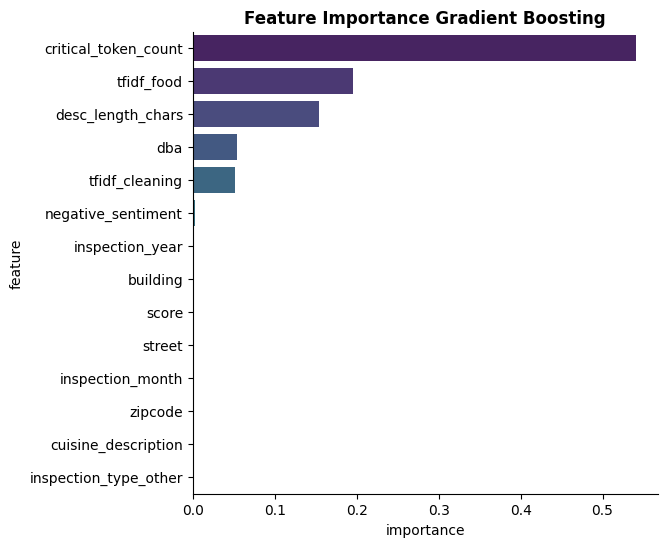

In [6]:
# get feature importance
feature_importance = model.feature_importances_

# get feature names
feature_names = model.feature_names_in_

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance}).sort_values('importance', ascending=False)

# plot feature importance
plt.figure(figsize=(6, 6))
sns.barplot(data=feature_importance_df, y='feature', x='importance', hue='feature', palette='viridis')
plt.title('Feature Importance Gradient Boosting', fontsize=12, fontweight='bold')
sns.despine()
plt.show()

### Shap Values

PermutationExplainer explainer: 101it [01:16,  1.21it/s]                         


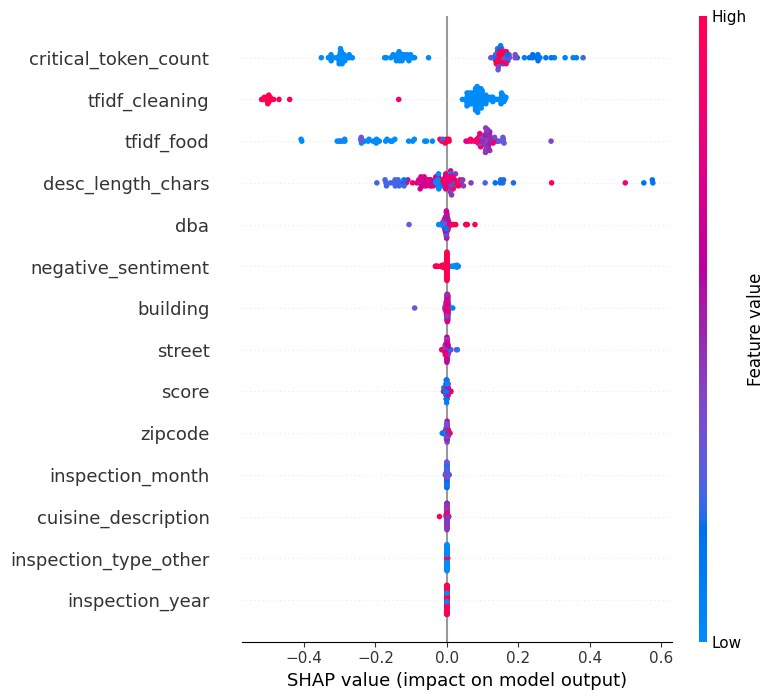

In [7]:
# set seed for reproducibility
np.random.seed(42)

# sample 100 rows from X_test for faster computation
X_sample = X_test.sample(100)

# Shap (SHapley Additive exPlanations)
explainer = shap.Explainer(model.predict_proba, X_sample)
shap_values = explainer(X_sample)

# shap summary plot for "Critical"
shap_values_class1 = shap_values[:, :, 1]
shap.summary_plot(shap_values_class1, X_sample)

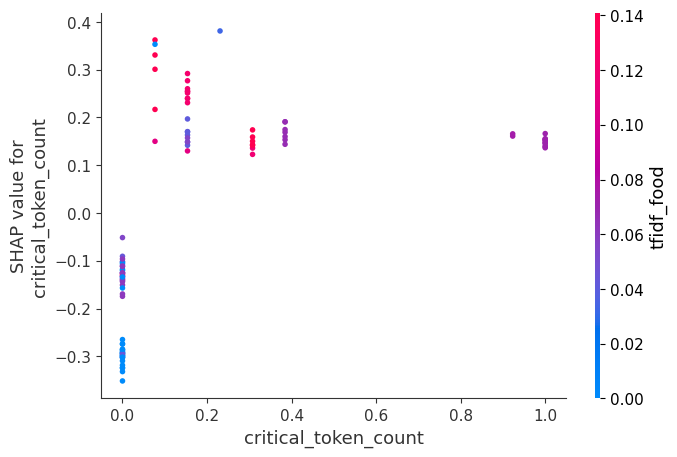

In [8]:
# shap dependence plot for "Critical"
shap.dependence_plot('critical_token_count', shap_values_class1.values, X_sample)

### Other Insights

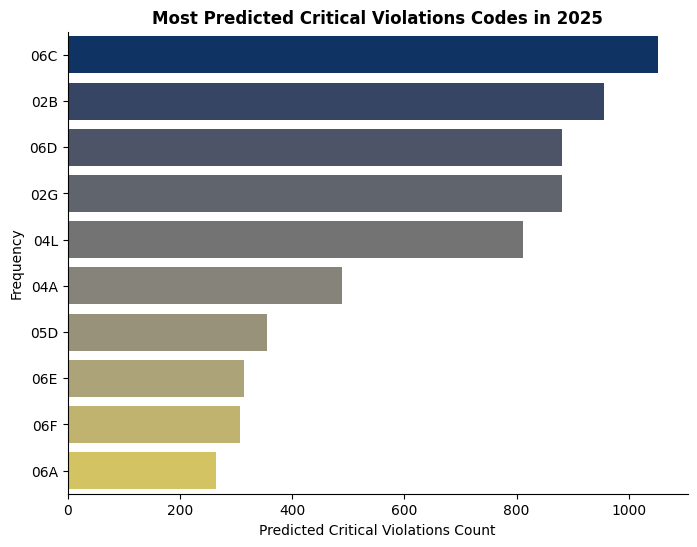

In [25]:
# for inspections in 2025
y_pred = model.predict(X_test)

# merge predictions with real data
y_pred_df = pd.DataFrame({'y_pred': y_pred}, index=y_test.index)
test_df_subset = test_df[['violation_code']]
pred_per_area_df = pd.concat([test_df_subset, y_pred_df], axis=1)

# count predicted critical violations by area and code
agg_df = (
    pred_per_area_df[pred_per_area_df['y_pred'] == 1]
    .groupby(['violation_code'])
    .size()
    .reset_index(name='predicted_critical_count')
    .sort_values('predicted_critical_count', ascending=False)
)
top_10 = agg_df.head(10)

plt.figure(figsize=(8, 6))
sns.barplot(data=top_10, y='violation_code', x='predicted_critical_count',hue='violation_code', palette='cividis', legend=False)
plt.title('Most Predicted Critical Violations Codes in 2025', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Critical Violations Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
sns.despine()
plt.show()

### GenAI - Health Department Alert

In [9]:
# gets unique descriptions per violation_code 
# those with multiple descriptions stay with the longest description
violations_df = (
    combined_df
    .sort_values('violation_description', key=lambda col: col.str.len(), ascending=False)
    .drop_duplicates(subset='violation_code')
    .loc[:, ['violation_code', 'violation_description']]
    .reset_index(drop=True)
)

violations_df.head(3)

,violation_code,violation_description
0,02A,time temperature control safety tc food cooked...
1,05D,hand washing facility adjacent toilet room wit...
2,03A,food prohibited unapproved unknown source home...


Timestamps per set:
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>min</th>
      <th>max</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>train</th>
      <td>2015-09-24</td>
      <td>2024-07-02</td>
    </tr>
    <tr>
      <th>val</th>
      <td>2024-07-02</td>
      <td>2024-12-12</td>
    </tr>
    <tr>
      <th>test</th>
      <td>2024-12-12</td>
      <td>2025-05-31</td>
    </tr>
  </tbody>
</table>
</div>

In [10]:
# for inspections in 2025
y_pred = model.predict(X_test)

# merge predictions with real data
y_pred_df = pd.DataFrame({'y_pred': y_pred}, index=y_test.index)
test_df_subset = test_df[['violation_code', 'boro', 'zipcode']]
pred_per_area_df = pd.concat([test_df_subset, y_pred_df], axis=1)

# count predicted critical violations by area and code
agg_df = (
    pred_per_area_df[pred_per_area_df['y_pred'] == 1]
    .groupby(['boro', 'zipcode', 'violation_code'])
    .size()
    .reset_index(name='predicted_critical_count')
    .sort_values('predicted_critical_count', ascending=False)
)

agg_df.head(3)

,boro,zipcode,violation_code,predicted_critical_count
996,Manhattan,10003,06C,37
1998,Queens,11372,06C,33
1817,Queens,11354,06C,29


In [11]:
# merge descriptions into aggregated data
if 'violation_description' not in agg_df.columns:
    agg_df = agg_df.merge(violations_df, on='violation_code', how='left')

agg_df.head(3)

,boro,zipcode,violation_code,predicted_critical_count,violation_description
0,Manhattan,10003,06C,37,food supply equipment protected potential sour...
1,Queens,11372,06C,33,food supply equipment protected potential sour...
2,Queens,11354,06C,29,food supply equipment protected potential sour...


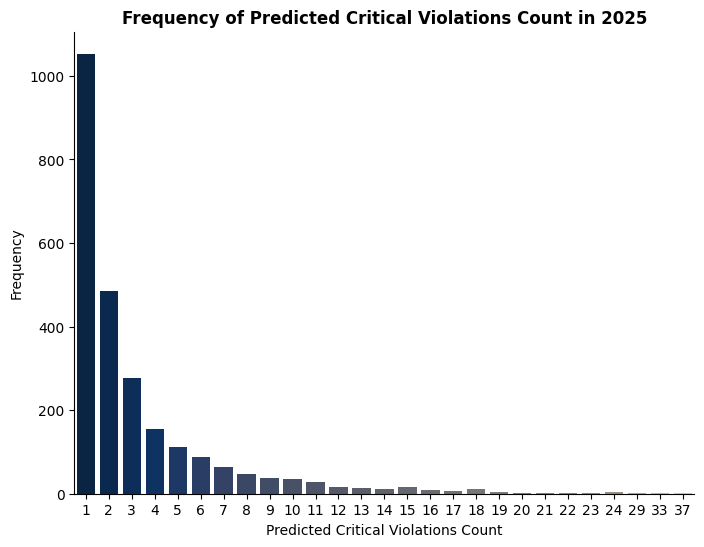

In [12]:
plot_data = agg_df.predicted_critical_count.value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=plot_data.index, y=plot_data.values, hue=plot_data.index, palette='cividis', legend=False)
plt.title('Frequency of Predicted Critical Violations Count in 2025', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Critical Violations Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
sns.despine()
plt.show()

In [13]:
n_violations = 7

# check how many areas have more than n_violations critical violations
high_risk = agg_df.loc[agg_df['predicted_critical_count'] >= n_violations].copy()

print(f'{round(len(high_risk)/len(agg_df)*100, 2)}% of areas have more than {n_violations} predicted critical violations.')

12.7% of areas have more than 7 predicted critical violations.


In [14]:
# function to generate a short alert per row
def generate_alert_text(row, generator, max_length=60):
    prompt = (
        f'Health Alert: In {row["boro"]}, ZIP code {row["zipcode"]}, there has been a rise in critical health violations. '
        f'The most common issue is: \'{row["violation_description"]}\'. '
        f'The health department advises caution.'
    )
    out = generator(prompt, max_length=max_length, num_return_sequences=1, truncation=True)
    return out[0]['generated_text']

def suggest_health_department(row, generator, max_length=40):
    prompt = (
        f'In {row["boro"]}, ZIP code {row["zipcode"]}, which local public health department or agency '
        f'(e.g., NYC Department of Health, Queens Health Office, etc.) should handle a surge in critical violations? '
        f'Suggest the most appropriate agency.'
    )
    out = generator(prompt, max_length=max_length, num_return_sequences=1, truncation=True)
    return out[0]['generated_text']

# generate alerts
high_risk['alert'] = high_risk.apply(lambda row: generate_alert_text(row, generator), axis=1)
high_risk['recommended_agency'] = high_risk.apply(lambda row: suggest_health_department(row, generator), axis=1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_

In [16]:
# save high_risk dataframe
high_risk.to_csv(join(processed_data_path, 'high_risk.csv'), index=False)

In [28]:
high_risk.alert.value_counts().idxmax()

"Health Alert: In Manhattan, ZIP code 10003, there has been a rise in critical health violations. The most common issue is: 'food supply equipment protected potential source contamination storage preparation transportation display service customer refillable reusable container condiment single service container dispensed directly vendor'. The health department advises caution. that contaminated containers are not suitable for use in this situation.\n\n\n\n\nThe most common health problems in the United States are:\n\n\n\n\n\n\nThe following are the health and safety hazards that can occur in high-tech manufacturing facilities:\n\n\n\n\n\n\n\n\nInjection:\n\n\n\n\n\n\n\n\n\nInjection:\n\n\nThe following are the health and safety hazards that can occur in high-tech manufacturing facilities:\n\n\nPreventions:\n\n\n\n\n\n\n\n\n\n\nInjection:\n\n\n\nThe following are the health and safety hazards that can occur in high-tech manufacturing facilities:\nPreventions:\nPreventions:\nPreventions: